# simulation 3

## test on SBM graph

In [1]:
# simulation 3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.utils import is_symmetric
from graspy.simulations import sbm
from graspy.plot import heatmap
from scipy.stats import ttest_ind, mannwhitneyu, fisher_exact,wilcoxon
from statsmodels.stats.weightstats import ztest
%matplotlib inline

ModuleNotFoundError: No module named 'statsmodels'

## generate 2 populations & visualization

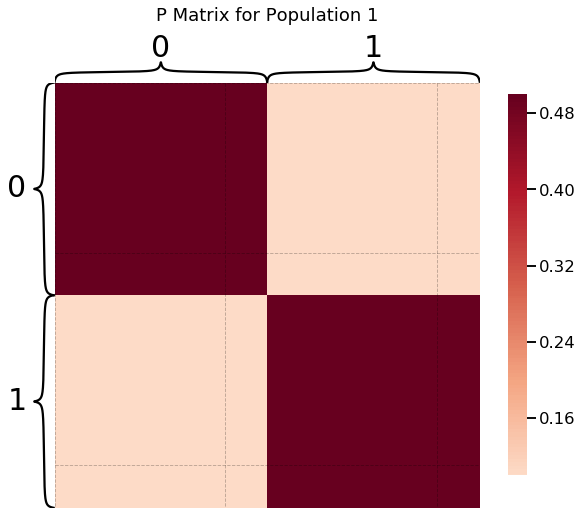

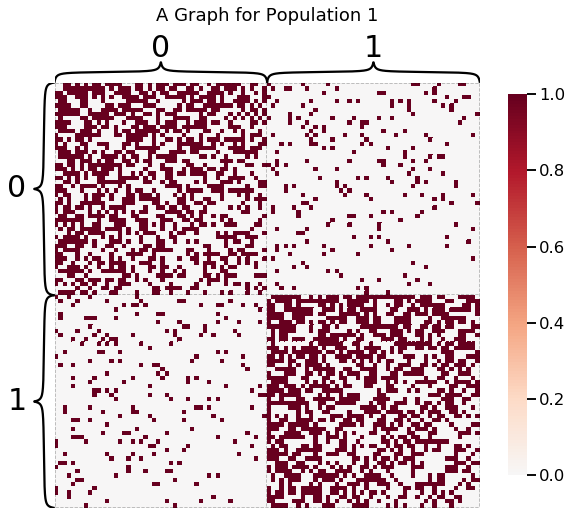

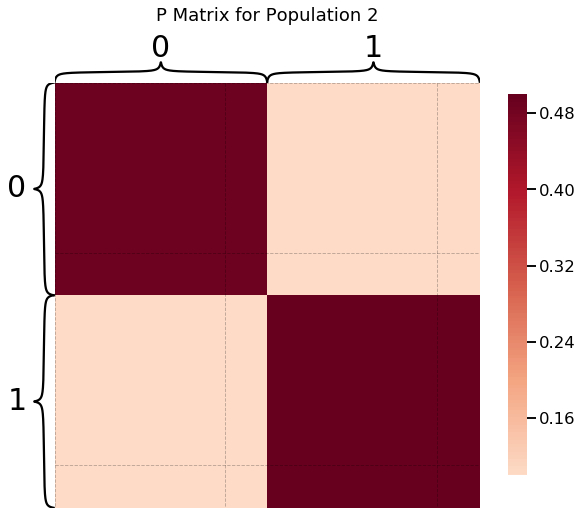

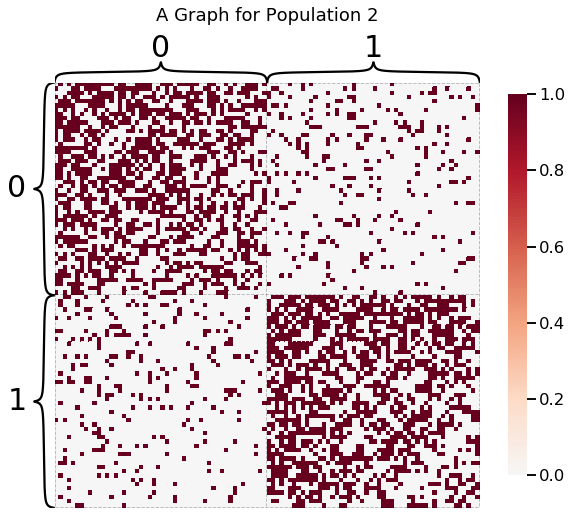

In [2]:
# SBM simulation
np.random.seed(8989)
n = 100
m = 10
b = 0.5
eps = 0.01
n_iter = 30

n_sbm = [int(n/2),int(n/2)]
n_labels = [0] * int(n / 2) + [1] * int(n / 2)
P1 = np.array([[b, 0.1],
             [0.1, 0.5]])
P2 = np.array([[b-eps, 0.1],
              [0.1, 0.5]])

for i in range(m):
    if i==0:
        y1 = sbm(n=n_sbm, p=P1)
        y1 = np.expand_dims(y1,2)
    else:
        y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)
       
for i in range(m):
    if i==0:
        y2 = sbm(n=n_sbm, p=P2)
        y2 = np.expand_dims(y2,2)
    else:
        y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)

# plot1
# visualization

heatmap(P1, title='P Matrix for Population 1',inner_hier_labels=[0,1])

heatmap(y1[:,:,0], title='A Graph for Population 1', inner_hier_labels=n_labels)

heatmap(P2, title='P Matrix for Population 2',inner_hier_labels=[0,1])

heatmap(y2[:,:,0], title='A Graph for Population 2', inner_hier_labels=n_labels)


## T-test
### blockwise t-test and heatmap visualization

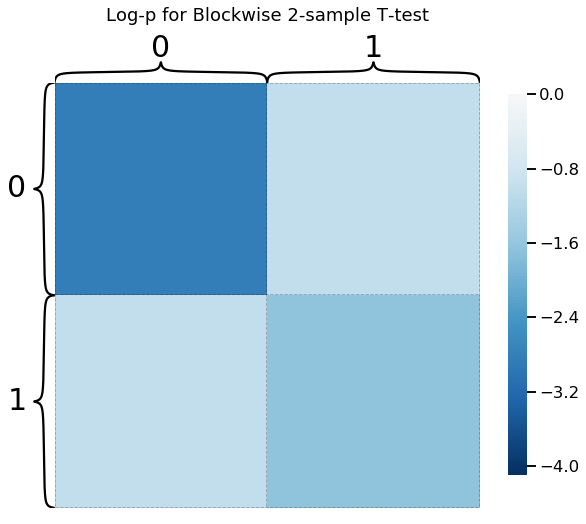

In [3]:
# blockwise t-test 
# similar to sim 8
indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]
p_blocks = np.zeros((num_blocks,num_blocks))
for i in np.arange(num_blocks):
    if i==0:
        start_i = 0
    else:
        start_i = indices_1[i-1]
    end_i = indices_1[i]
    for j in np.arange(i,num_blocks):
        if j==0:
            start_j = 0
        else:
            start_j = indices_1[j-1]
        end_j = indices_1[j]

        block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
        block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

        #don't be redundant - only use upper triangle if on a diagonal block
        if i == j:
            idxs = np.triu_indices(n_sbm[i],1)
            binoms_1 = block_1[idxs]
            ones_1 = np.sum(binoms_1)
            zeros_1 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_1
            
            binoms_2 = block_2[idxs]
            ones_2 = np.sum(binoms_2)
            zeros_2 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_2
        else:
            binoms_1 = block_1.flatten()
            ones_1 = np.sum(binoms_1)
            zeros_1 = n_sbm[i]**2*m - ones_1
            
            binoms_2 = block_2.flatten()
            ones_2 = np.sum(binoms_2)
            zeros_2 = n_sbm[j]**2*m - ones_2
            
        _,p = ttest_ind(binoms_1,binoms_2)
        p_blocks[i,j] = p
        p_blocks[j,i] = p
        # print(p)

num_tests = num_blocks*(num_blocks+1)/2
alpha_corrected = 0.05/num_tests
blockwise_sig = np.sum(p_blocks < alpha_corrected)
# print("Number of significant blocks from 2-sample T-test with a=0.05, Bonferroni Correction: " + str(blockwise_sig))

vmin = np.log(alpha_corrected)

b00 = p_blocks[0,0]*np.ones((n_sbm[0],n_sbm[0]))
b01 = p_blocks[0,1]*np.ones((n_sbm[0],n_sbm[1]))
b10 = p_blocks[1,0]*np.ones((n_sbm[1],n_sbm[0]))
b11 = p_blocks[1,1]*np.ones((n_sbm[1],n_sbm[1]))
top = np.concatenate((b00,b01),axis=1)
bottom = np.concatenate((b10,b11),axis=1)
output = np.concatenate((top,bottom),axis=0)

plot = heatmap(output,inner_hier_labels=n_labels,
	title ='Log-p for Blockwise 2-sample T-test',
	transform='log',vmin=vmin,vmax=0)

## T-test, 30 times
### blockwise t-test and  beeswarm visualization

Text(0.5, 1.0, 't test')

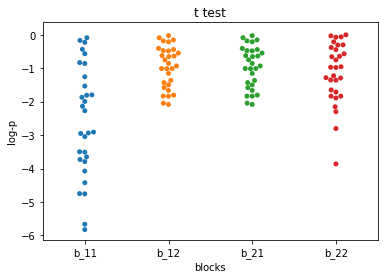

In [4]:
# t-test
indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]
p_blocks = np.zeros((num_blocks,num_blocks))
p_value = pd.DataFrame(columns=["blocks","log-p"])
for k in range(30):
    for i in range(m):
        if i==0:
            y1 = sbm(n=n_sbm, p=P1)
            y1 = np.expand_dims(y1,2)
        else:
            y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)
       
    for i in range(m):
        if i==0:
            y2 = sbm(n=n_sbm, p=P2)
            y2 = np.expand_dims(y2,2)
        else:
            y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)
            
    for i in np.arange(num_blocks):
        if i==0:
            start_i = 0
        else:
            start_i = indices_1[i-1]
        end_i = indices_1[i]
        for j in np.arange(i,num_blocks):
            if j==0:
                start_j = 0
            else:
                start_j = indices_1[j-1]
            end_j = indices_1[j]

            block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
            block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

            #don't be redundant - only use upper triangle if on a diagonal block
            if i == j:
                idxs = np.triu_indices(n_sbm[i],1)
                binoms_1 = block_1[idxs]
                ones_1 = np.sum(binoms_1)
                zeros_1 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_1

                binoms_2 = block_2[idxs]
                ones_2 = np.sum(binoms_2)
                zeros_2 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_2
            else:
                binoms_1 = block_1.flatten()
                ones_1 = np.sum(binoms_1)
                zeros_1 = n_sbm[i]**2*m - ones_1

                binoms_2 = block_2.flatten()
                ones_2 = np.sum(binoms_2)
                zeros_2 = n_sbm[j]**2*m - ones_2

            _,p = ttest_ind(binoms_1,binoms_2)
            p_blocks[i,j] = p
            p_blocks[j,i] = p
            # print(p)
    
    p_value = p_value.append(pd.DataFrame({"blocks":["b_11"],"log-p":[np.log(p_blocks[0,0])]}),ignore_index=True,sort=False)
    p_value = p_value.append(pd.DataFrame({"blocks":["b_12"],"log-p":[np.log(p_blocks[0,1])]}),ignore_index=True,sort=False)
    p_value = p_value.append(pd.DataFrame({"blocks":["b_21"],"log-p":[np.log(p_blocks[1,0])]}),ignore_index=True,sort=False)
    p_value = p_value.append(pd.DataFrame({"blocks":["b_22"],"log-p":[np.log(p_blocks[1,1])]}),ignore_index=True,sort=False)
    
sns.swarmplot(x="blocks",y="log-p",data=p_value)
plt.title("t test")

##  Wilcoxon test, 30 times
### blockwise Wilcoxon test and  beeswarm visualization

Text(0.5, 1.0, 'Wilcoxon test')

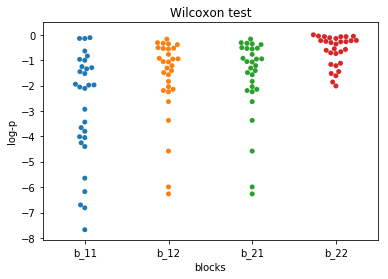

In [5]:
# wilcoxon test
indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]
p_blocks = np.zeros((num_blocks,num_blocks))
p_value = pd.DataFrame(columns=["blocks","log-p"])
for k in range(30):
    for i in range(m):
        if i==0:
            y1 = sbm(n=n_sbm, p=P1)
            y1 = np.expand_dims(y1,2)
        else:
            y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)
       
    for i in range(m):
        if i==0:
            y2 = sbm(n=n_sbm, p=P2)
            y2 = np.expand_dims(y2,2)
        else:
            y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)
            
    for i in np.arange(num_blocks):
        if i==0:
            start_i = 0
        else:
            start_i = indices_1[i-1]
        end_i = indices_1[i]
        for j in np.arange(i,num_blocks):
            if j==0:
                start_j = 0
            else:
                start_j = indices_1[j-1]
            end_j = indices_1[j]

            block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
            block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

            #don't be redundant - only use upper triangle if on a diagonal block
            if i == j:
                idxs = np.triu_indices(n_sbm[i],1)
                binoms_1 = block_1[idxs]
                ones_1 = np.sum(binoms_1)
                zeros_1 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_1

                binoms_2 = block_2[idxs]
                ones_2 = np.sum(binoms_2)
                zeros_2 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_2
            else:
                binoms_1 = block_1.flatten()
                ones_1 = np.sum(binoms_1)
                zeros_1 = n_sbm[i]**2*m - ones_1

                binoms_2 = block_2.flatten()
                ones_2 = np.sum(binoms_2)
                zeros_2 = n_sbm[j]**2*m - ones_2

            _,p = wilcoxon(binoms_1,binoms_2)
            p_blocks[i,j] = p
            p_blocks[j,i] = p
            # print(p)
    
    p_value = p_value.append(pd.DataFrame({"blocks":["b_11"],"log-p":[np.log(p_blocks[0,0])]}),ignore_index=True,sort=False)
    p_value = p_value.append(pd.DataFrame({"blocks":["b_12"],"log-p":[np.log(p_blocks[0,1])]}),ignore_index=True,sort=False)
    p_value = p_value.append(pd.DataFrame({"blocks":["b_21"],"log-p":[np.log(p_blocks[1,0])]}),ignore_index=True,sort=False)
    p_value = p_value.append(pd.DataFrame({"blocks":["b_22"],"log-p":[np.log(p_blocks[1,1])]}),ignore_index=True,sort=False)
    
sns.swarmplot(x="blocks",y="log-p",data=p_value)
plt.title("Wilcoxon test")

## Mann-Whitey U test, fisher test, z-test
## beeswarm visualization

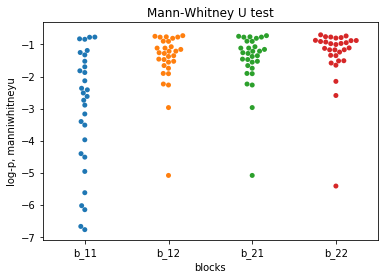

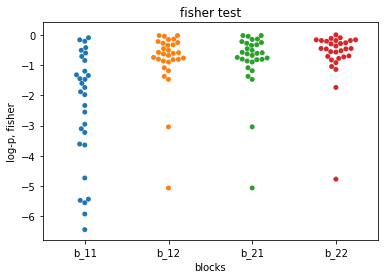

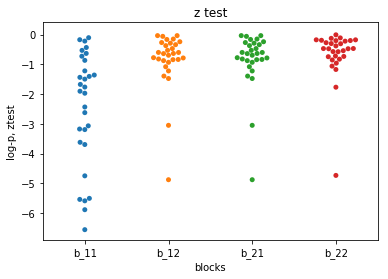

In [6]:

indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]
pm_blocks = np.zeros((num_blocks,num_blocks))
pz_blocks = np.zeros((num_blocks,num_blocks))
pf_blocks = np.zeros((num_blocks,num_blocks))
pm_value = pd.DataFrame(columns=["blocks","log-p, mannwhiteyu"])
pz_value = pd.DataFrame(columns=["blocks","log-p, ztest"])
pf_value = pd.DataFrame(columns=["blocks","log-p, fisher"])

for k in range(30):
    for i in range(m):
        if i==0:
            y1 = sbm(n=n_sbm, p=P1)
            y1 = np.expand_dims(y1,2)
        else:
            y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)
       
    for i in range(m):
        if i==0:
            y2 = sbm(n=n_sbm, p=P2)
            y2 = np.expand_dims(y2,2)
        else:
            y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)
            
    for i in np.arange(num_blocks):
        if i==0:
            start_i = 0
        else:
            start_i = indices_1[i-1]
        end_i = indices_1[i]
        for j in np.arange(i,num_blocks):
            if j==0:
                start_j = 0
            else:
                start_j = indices_1[j-1]
            end_j = indices_1[j]

            block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
            block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

            #don't be redundant - only use upper triangle if on a diagonal block
            if i == j:
                idxs = np.triu_indices(n_sbm[i],1)
                binoms_1 = block_1[idxs]
                ones_1 = np.sum(binoms_1)
                zeros_1 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_1

                binoms_2 = block_2[idxs]
                ones_2 = np.sum(binoms_2)
                zeros_2 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_2
            else:
                binoms_1 = block_1.flatten()
                ones_1 = np.sum(binoms_1)
                zeros_1 = n_sbm[i]**2*m - ones_1

                binoms_2 = block_2.flatten()
                ones_2 = np.sum(binoms_2)
                zeros_2 = n_sbm[j]**2*m - ones_2

            # mannwhitneyu
            _,p = mannwhitneyu(binoms_1,binoms_2)
            pm_blocks[i,j] = p
            pm_blocks[j,i] = p
            
            # fisher
            table = np.array([[ones_1,zeros_1],
                             [ones_2,zeros_2]])
            _,p = fisher_exact(table)
            pf_blocks[i,j] = p
            pf_blocks[j,i] = p
            
            # z-test
            _,p = ztest(binoms_1,binoms_2)
            pz_blocks[i,j] = p
            pz_blocks[j,i] = p
    
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_11"],"log-p, manniwhitneyu":[np.log(pm_blocks[0,0])]}),ignore_index=True,sort=False)
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_12"],"log-p, manniwhitneyu":[np.log(pm_blocks[0,1])]}),ignore_index=True,sort=False)
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_21"],"log-p, manniwhitneyu":[np.log(pm_blocks[1,0])]}),ignore_index=True,sort=False)
    pm_value = pm_value.append(pd.DataFrame({"blocks":["b_22"],"log-p, manniwhitneyu":[np.log(pm_blocks[1,1])]}),ignore_index=True,sort=False)
    
    pf_value = pf_value.append(pd.DataFrame({"blocks":["b_11"],"log-p, fisher":[np.log(pf_blocks[0,0])]}),ignore_index=True,sort=False)
    pf_value = pf_value.append(pd.DataFrame({"blocks":["b_12"],"log-p, fisher":[np.log(pf_blocks[0,1])]}),ignore_index=True,sort=False)
    pf_value = pf_value.append(pd.DataFrame({"blocks":["b_21"],"log-p, fisher":[np.log(pf_blocks[1,0])]}),ignore_index=True,sort=False)
    pf_value = pf_value.append(pd.DataFrame({"blocks":["b_22"],"log-p, fisher":[np.log(pf_blocks[1,1])]}),ignore_index=True,sort=False)
   
    pz_value = pz_value.append(pd.DataFrame({"blocks":["b_11"],"log-p, ztest":[np.log(pz_blocks[0,0])]}),ignore_index=True,sort=False)
    pz_value = pz_value.append(pd.DataFrame({"blocks":["b_12"],"log-p, ztest":[np.log(pz_blocks[0,1])]}),ignore_index=True,sort=False)
    pz_value = pz_value.append(pd.DataFrame({"blocks":["b_21"],"log-p, ztest":[np.log(pz_blocks[1,0])]}),ignore_index=True,sort=False)
    pz_value = pz_value.append(pd.DataFrame({"blocks":["b_22"],"log-p, ztest":[np.log(pz_blocks[1,1])]}),ignore_index=True,sort=False)
   
plt.figure()
plt.title("Mann-Whitney U test")
sns.swarmplot(x="blocks",y="log-p, manniwhitneyu",data=pm_value)
plt.figure()
plt.title("fisher test")
sns.swarmplot(x="blocks",y="log-p, fisher",data=pf_value)
plt.figure()
plt.title("z test")
sns.swarmplot(x="blocks",y="log-p, ztest",data=pz_value)

In [7]:
n =100
n_sbm = [int(n/2),int(n/2)]
eps=0.01
m = 10
n_b = int((1-eps*2)/0.01+1)
n_iter = 200
indices_1 = np.cumsum(n_sbm)
num_blocks = indices_1.shape[0]

p_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pw_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pm_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pz_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))
pf_b_value = np.zeros((num_blocks,num_blocks,n_iter,n_b))

for rank_b in range(n_b):
    b = eps + 0.01 * rank_b
    # print(b)
    
    # P matrix for different b
    P1 = np.array([[b, 0.1],
                 [0.1, 0.5]])
    P2 = np.array([[b-eps, 0.1],
                    [0.1, 0.5]])
    '''
    if b<0.5:
        P2 = np.array([[b+eps, 0.1],
                        [0.1, 0.5]]) 
    else:
        P2 = np.array([[b-eps, 0.1],
                        [0.1, 0.5]])
    '''
    for k in range(n_iter):
        
        # generate sbm matrix for population 1 and population 2
        for i in range(m):
            if i==0:
                y1 = sbm(n=n_sbm, p=P1)
                y1 = np.expand_dims(y1,2)
            else:
                y1 = np.append(y1,np.expand_dims(sbm(n=n_sbm, p=P1),2),axis=2)

        for i in range(m):
            if i==0:
                y2 = sbm(n=n_sbm, p=P2)
                y2 = np.expand_dims(y2,2)
            else:
                y2 = np.append(y2,np.expand_dims(sbm(n=n_sbm, p=P2),2),axis=2)

        # calculate P value of 3 blocks        
        for i in np.arange(num_blocks):
            
            if i==0:
                start_i = 0
            else:
                start_i = indices_1[i-1]
            end_i = indices_1[i]
            
            for j in np.arange(i,num_blocks):
                if j==0:
                    start_j = 0
                else:
                    start_j = indices_1[j-1]
                end_j = indices_1[j]

                # single block for population 1 and population 2
                block_1 = np.sum(y1[start_i:end_i,start_j:end_j,:],axis=2)
                block_2 = np.sum(y2[start_i:end_i,start_j:end_j,:],axis=2)

                #don't be redundant - only use upper triangle if on a diagonal block
                # get data set used for test
                if i == j:
                    idxs = np.triu_indices(n_sbm[i],1)
                    binoms_1 = block_1[idxs]
                    ones_1 = np.sum(binoms_1)
                    zeros_1 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_1

                    binoms_2 = block_2[idxs]
                    ones_2 = np.sum(binoms_2)
                    zeros_2 = n_sbm[i]*(n_sbm[i]-1)*m/2 - ones_2
                else:
                    binoms_1 = block_1.flatten()
                    ones_1 = np.sum(binoms_1)
                    zeros_1 = n_sbm[i]**2*m - ones_1

                    binoms_2 = block_2.flatten()
                    ones_2 = np.sum(binoms_2)
                    zeros_2 = n_sbm[j]**2*m - ones_2

                # t-test    
                _,p = ttest_ind(binoms_1,binoms_2)
                p_b_value[i,j,k,rank_b]=p
                p_b_value[i,j,k,rank_b]=p
                
                # wilcoxon test
                _,pw = wilcoxon(binoms_1,binoms_2)
                pw_b_value[i,j,k,rank_b]=pw
                pw_b_value[i,j,k,rank_b]=pw
                
                # manniwhitneyu test
                _,p = mannwhitneyu(binoms_1,binoms_2)
                pm_b_value[i,j,k,rank_b]=p
                pm_b_value[i,j,k,rank_b]=p
                
                # z-test
                _,p = ztest(binoms_1,binoms_2)
                pz_b_value[i,j,k,rank_b]=p
                pz_b_value[i,j,k,rank_b]=p
                
                # fisher test
                table = np.array([[ones_1,zeros_1],
                                 [ones_2,zeros_2]])
                _,p = fisher_exact(table)
                pf_b_value[i,j,k,rank_b]=p
                pf_b_value[i,j,k,rank_b]=p

In [8]:
# calculate power and type 1 error
# using the results got in above cell
alpha = 0.05
power_b11 = np.zeros(n_b)
powerw_b11 = np.zeros(n_b)
error_b12 = np.zeros(n_b)
errorw_b12 = np.zeros(n_b)
error_b22 = np.zeros(n_b)
errorw_b22 = np.zeros(n_b)

powerm_b11 = np.zeros(n_b)
errorm_b12 = np.zeros(n_b)
errorm_b22 = np.zeros(n_b)

powerz_b11 = np.zeros(n_b)
errorz_b12 = np.zeros(n_b)
errorz_b22 = np.zeros(n_b)

powerf_b11 = np.zeros(n_b)
errorf_b12 = np.zeros(n_b)
errorf_b22 = np.zeros(n_b)

for rank_b in range(n_b):
    # calculate power for block_11 
    power_b11[rank_b] = np.count_nonzero(p_b_value[0,0,:,rank_b]<alpha)/n_iter
    powerw_b11[rank_b] = np.count_nonzero(pw_b_value[0,0,:,rank_b]<alpha)/n_iter
    powerm_b11[rank_b] = np.count_nonzero(pm_b_value[0,0,:,rank_b]<alpha)/n_iter
    powerz_b11[rank_b] = np.count_nonzero(pz_b_value[0,0,:,rank_b]<alpha)/n_iter
    powerf_b11[rank_b] = np.count_nonzero(pf_b_value[0,0,:,rank_b]<alpha)/n_iter
    
    # calculate type1 error for block_12 and block_22
    error_b12[rank_b] = np.count_nonzero(p_b_value[0,1,:,rank_b]<alpha)/n_iter
    errorw_b12[rank_b] = np.count_nonzero(pw_b_value[0,1,:,rank_b]<alpha)/n_iter
    errorm_b12[rank_b] = np.count_nonzero(pm_b_value[0,1,:,rank_b]<alpha)/n_iter
    errorz_b12[rank_b] = np.count_nonzero(pz_b_value[0,1,:,rank_b]<alpha)/n_iter
    errorf_b12[rank_b] = np.count_nonzero(pf_b_value[0,1,:,rank_b]<alpha)/n_iter
    
    error_b22[rank_b] = np.count_nonzero(p_b_value[1,1,:,rank_b]<alpha)/n_iter
    errorw_b22[rank_b] = np.count_nonzero(pw_b_value[1,1,:,rank_b]<alpha)/n_iter
    errorm_b22[rank_b] = np.count_nonzero(pm_b_value[1,1,:,rank_b]<alpha)/n_iter
    errorz_b22[rank_b] = np.count_nonzero(pz_b_value[1,1,:,rank_b]<alpha)/n_iter
    errorf_b22[rank_b] = np.count_nonzero(pf_b_value[1,1,:,rank_b]<alpha)/n_iter

Text(0.5, 1.0, 'block 22, m=10, n_iter=200')

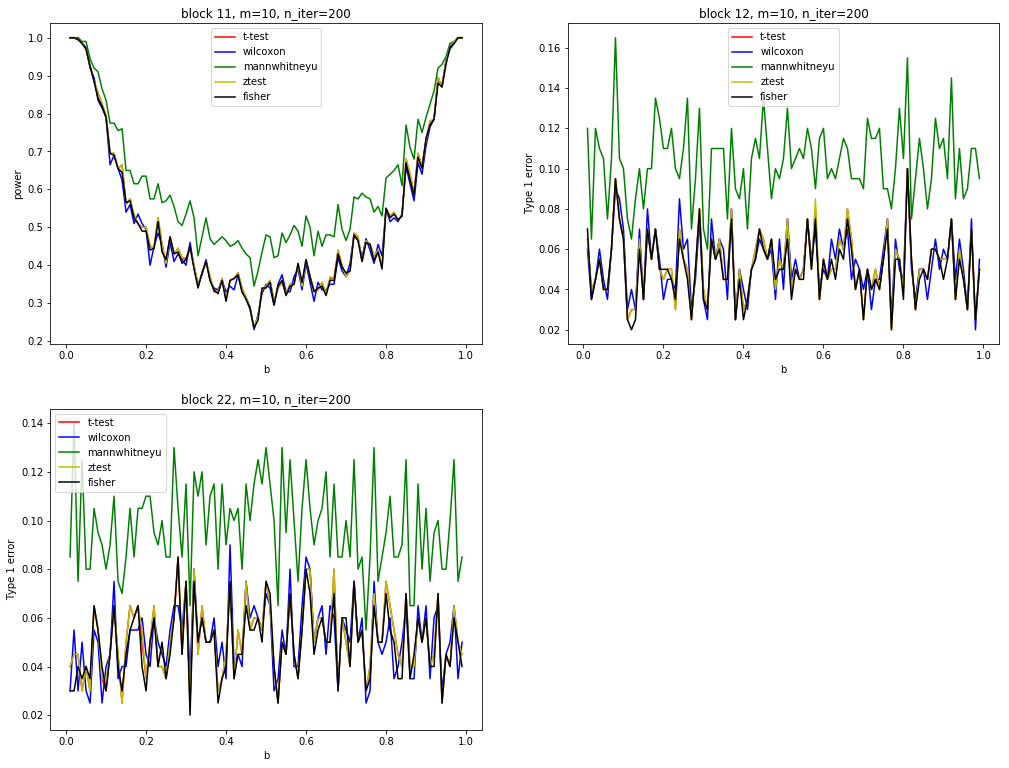

In [9]:
# visualization
# plot power and type 1 error
plt.figure(figsize=(17,13))
plt.subplot(221)
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),power_b11,'r', label='t-test')
plt.xlabel("b")
plt.ylabel("power")
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerw_b11,'b', label='wilcoxon')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerm_b11,'g', label='mannwhitneyu')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerz_b11,'y', label='ztest')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),powerf_b11,'black', label='fisher')
plt.legend()
plt.title("block 11, m="+str(m)+", n_iter="+str(n_iter))

plt.subplot(222)
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),error_b12,'r', label='t-test')
plt.xlabel("b")
plt.ylabel("Type 1 error")
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorw_b12,'b', label='wilcoxon')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorm_b12,'g', label='mannwhitneyu')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorz_b12,'y', label='ztest')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorf_b12,'black', label='fisher')
plt.legend()
plt.title("block 12, m="+str(m)+", n_iter="+str(n_iter))

plt.subplot(223)
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),error_b22,'r', label='t-test')
plt.xlabel("b")
plt.ylabel("Type 1 error")
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorw_b22,'b', label='wilcoxon')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorm_b22,'g', label='mannwhitneyu')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorz_b22,'y', label='ztest')
plt.plot(np.linspace(start=eps, stop=1-eps, num=n_b),errorf_b22,'black', label='fisher')
plt.legend()
plt.title("block 22, m="+str(m)+", n_iter="+str(n_iter))